In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import pickle

In [3]:
#Create a function for the test data
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    
    #df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [4]:
df_train = read_dataframe("./data/fhv_tripdata_2021-01.parquet")
df_val = read_dataframe("./data/fhv_tripdata_2021-02.parquet")

In [14]:
df_train.dtypes

index                              int64
dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

# Q1

How many records in January

In [5]:
df_train.shape

(1154112, 8)

# Q2 

What's the average trip duration in January

In [6]:
df_train['duration'].mean()

19.1672240937939

In [7]:
df_train['duration'].mean(skipna = False)

19.167224093791006

# Duration Dist

Check the distribution of the duration variable. There are some outliers. Keep only those between 1 and 60 mins. How many records were dropped


<AxesSubplot:xlabel='duration', ylabel='Count'>

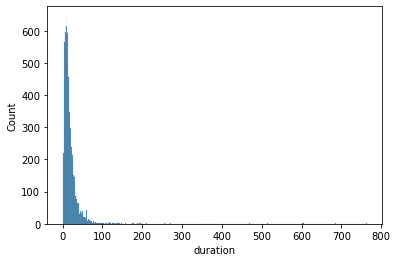

In [8]:
sns.histplot(df_train['duration'].sample(10000))

In [9]:
df_train.shape[0] - df_train[(df_train.duration >= 1) & (df_train.duration <= 60)].shape[0]

44286

In [10]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)].reset_index()
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)].reset_index()

# Q3 Missing Values

pickuplocation ID has a lot of missing values. Fill with -1. 

In [83]:
df_train = pd.read_parquet("./data/fhv_tripdata_2021-01.parquet")

In [11]:
df_train[df_train['PUlocationID'] == "nan"].shape[0] / df_train.shape[0]

0.8352732770722617

In [12]:
df_train.loc[df_train['PUlocationID'] == "nan","PUlocationID"] = -1
df_train.loc[df_train['DOlocationID'] == "nan","DOlocationID"] = -1 

In [13]:
df_val.loc[df_val['PUlocationID'] == "nan","PUlocationID"] = -1
df_val.loc[df_val['DOlocationID'] == "nan","DOlocationID"] = -1 

# Q4 One-hot encoding

In [17]:
categorical = ['PUlocationID', 'DOlocationID']

In [18]:
def encode_cat_to_dict(categor_list,df):
    df[categor_list] = df[categor_list].astype(str)
    df_dicts = df[categor_list].to_dict(orient = "records")
    
    return df_dicts
    

In [20]:
train_dicts = encode_cat_to_dict(categorical, df_train)
val_dicts = encode_cat_to_dict(categorical, df_val)

In [21]:
dv = DictVectorizer()

In [24]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [25]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [26]:
X_val

<990113x525 sparse matrix of type '<class 'numpy.float64'>'
	with 1980223 stored elements in Compressed Sparse Row format>

# Q5 Train Model

In [27]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = lr.predict(X_train)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


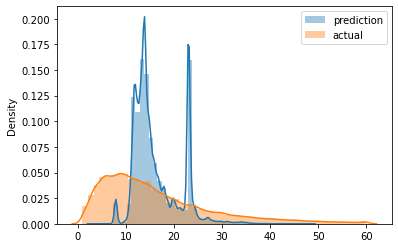

In [30]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train, label = "actual")

plt.legend()

In [31]:
#model is wrong on average by 9 mins = RMSE
mean_squared_error(y_train, y_pred, squared = False)

10.5285191072072

# Q6 Evaluation the Model 

Apply to the validation dataset. 

In [33]:
y_pred = lr.predict(X_val)
y_train = df_val[target].values

mean_squared_error(y_train, y_pred, squared = False)

11.014283163400654